<h1>Análise dos dados gerados em <strong> dataBase.gen.csv </strong> </h1>

<h2>
A base de dados escolhida consiste em um conjunto de dados que descrevem a rotina de compra de um ecommerce. Nela podemos visualizar diversas características de um produto, como o nome, preço, descrição, nota atribuída, comentários, local de compra, etc.

Por ser tão abrangente, essa análise será limitada ao sistema de avaliação feito pelos clientes após a confirmação de entrega do produto. Assim, o consumidor pode dar nota de 1 a 5 para o produto, sendo 1 o mais baixo e 5 o mais alto. Os comentários avaliativos serão desconsiderados para essa primeira proposta.

Com essas avaliações, a plataforma de e-commerce consegue tirar insights sobre a qualidade do produto e nisso trazer melhorias para o negócio. A grande questão que surge é: Seria possível prever a pontuação dos clientes com base em alguma outra métrica antes mesmo dessa avaliação ser efetuada? Caso sim, quais métodos e processos devemos seguir e em onde deveríamos direcionar esforços no negócio? No estudo em questão, o principal objetivo é elucidar esse problema, que é tentar prever a satisfação do cliente por meio de outras métricas para que o comércio eletrônico possa lançar mão de meios para mitigar eventuais danos em determinados casos. </h2>

<!-- Alguns requisitos que devem ser observados são:

1) Classificações baixas (1,2 e 3) são essenciais para a melhoria do negocio e devem ser analisada e classificadas corretamente;
2) O modelo não deve demorar muito para ser executado e fazer as previsões, já que essa previsão deve ser feita antes que o usuário dê a nota. -->


In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import abspath

# lendo dados que são gerados no dataClean.ipynb
data = pd.read_csv(abspath('./data/dataBase.gen.csv'))

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113105 entries, 0 to 113104
Data columns (total 38 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113105 non-null  object 
 1   payment_sequential             113105 non-null  int64  
 2   payment_type                   113105 non-null  object 
 3   payment_installments           113105 non-null  int64  
 4   payment_value                  113105 non-null  float64
 5   customer_id                    113105 non-null  object 
 6   order_status                   113105 non-null  object 
 7   order_purchase_timestamp       113105 non-null  object 
 8   order_approved_at              113105 non-null  object 
 9   order_delivered_carrier_date   113105 non-null  object 
 10  order_delivered_customer_date  113105 non-null  object 
 11  order_estimated_delivery_date  113105 non-null  object 
 12  review_score                  

<h2>Checando a distribuição de notas dadas pelos clientes</h2>


Total:
  5    64639
4    21724
1    13241
3     9573
2     3928
Name: review_score, dtype: int64
************************************************************
Porcentagem da distribuição:
  5    57.149551
4    19.206932
1    11.706821
3     8.463817
2     3.472879
Name: review_score, dtype: float64
************************************************************


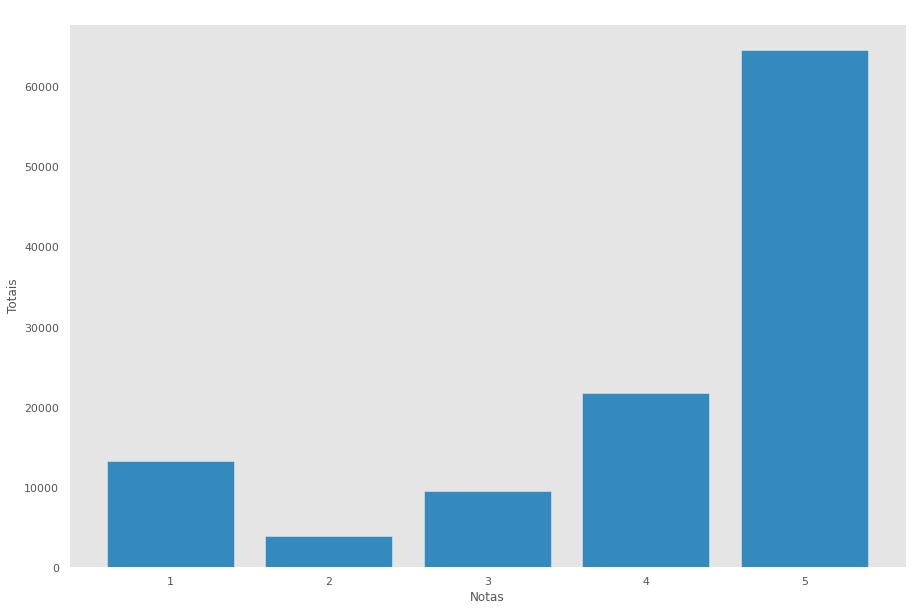

In [368]:
print("Total:\n ", data["review_score"].value_counts())
print("**"*30)
print("Porcentagem da distribuição:\n ", 100 *
      data["review_score"].value_counts(normalize=True))
print("**"*30)

plt.style.use('ggplot')
plt.figure(figsize=(15, 10))
plt.grid(b=False)
base_color = sns.color_palette()[1]

plt.bar(data["review_score"].value_counts().index,
        data["review_score"].value_counts(), color=base_color)

plt.xlabel("Notas")
plt.ylabel("Totais")
plt.title("Distribuição das notas")
plt.show()


https://academic.oup.com/forestscience/article-abstract/11/4/405/4746324?redirectedFrom=PDF

<h2>É possível perceber que essa distribuição é dada em forma de <strong>J</strong> e é bastante típica em ecommerces. Grande quantidade de avaliações 5, 4 e 1, pequena quantidade de 2 e 3. </h2>


<h2>Fazendo correlações entre todas as colunas, formamos uma matriz de calor onde quanto mais próximo de 1 (ou -1), maior a correlação de pearson da variável</h2>


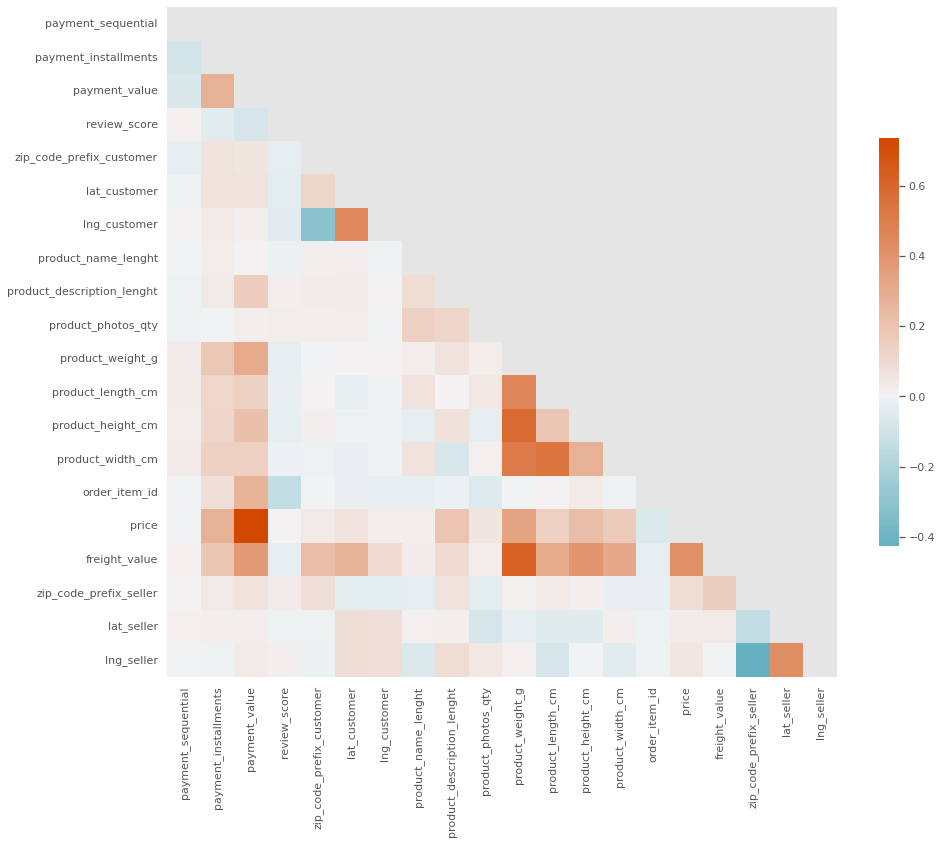

In [348]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html

correlation = data.corr()

mask = np.triu(np.ones_like(correlation, dtype='bool'))
f, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(220, 20, s=100, as_cmap=True, center="light")

sns.heatmap(correlation, mask=mask, cmap=cmap, center=0,
            square=True, cbar_kws={"shrink": .5})
plt.show()


<h2>O mapa de calor é um bom ponto de partida para podermos visualizar o comportamento geral dos dados que temos em mão, mas não é apenas com ele que devemos tomar decisões. Nele vemos algumas correlações interessantes, como por ex:
<ul> 
<li>Uma relação mais forte entre pesos e medidas dos produtos e o valor de frete</li>
<li>Uma relação forte entre pesos e medidas com o preço do produto</li>
</ul>
</h2>
</p>
<h2>Para as correlações da variável <i>review_score</i> podemos fazer o seguinte:</h2>

In [309]:
data.corr()["review_score"]

payment_sequential            0.007797
payment_installments         -0.043983
payment_value                -0.083145
review_score                  1.000000
zip_code_prefix_customer     -0.027204
lat_customer                 -0.037306
lng_customer                 -0.042771
product_name_lenght          -0.013664
product_description_lenght    0.014201
product_photos_qty            0.021787
product_weight_g             -0.027688
product_length_cm            -0.020950
product_height_cm            -0.023795
product_width_cm             -0.012398
order_item_id                -0.138068
price                         0.002240
freight_value                -0.034503
zip_code_prefix_seller        0.026775
lat_seller                   -0.009358
lng_seller                    0.012429
Name: review_score, dtype: float64

<h2>Para as notas dadas pelo cliente, vemos baixíssimas correlações, inclusive do preço e do frete.</h2>


<h1> ---> Análises univariadas com as variáveis de pagamento <--- </h1>

<h2>1) Agora tentemos outra abordagem e partamos para analisar a relação do tipo do pagamento com a nota de review. Essa correlação não é explicita no mapa, já que o tipo de pagamento é uma variável categórica, e não numérica. </h2>


In [310]:
pay_type_score = data.groupby("review_score")[
    "payment_type"].value_counts(normalize=True)
pay_type_score.unstack()


payment_type,boleto,credit_card,debit_card,voucher
review_score,,,,
1,0.195227,0.740427,0.011253,0.053093
2,0.186609,0.734216,0.013493,0.065682
3,0.201922,0.731954,0.012744,0.053379
4,0.198122,0.736098,0.013764,0.052016
5,0.192655,0.739012,0.015455,0.052878


<h2>Ou graficamente</h2>


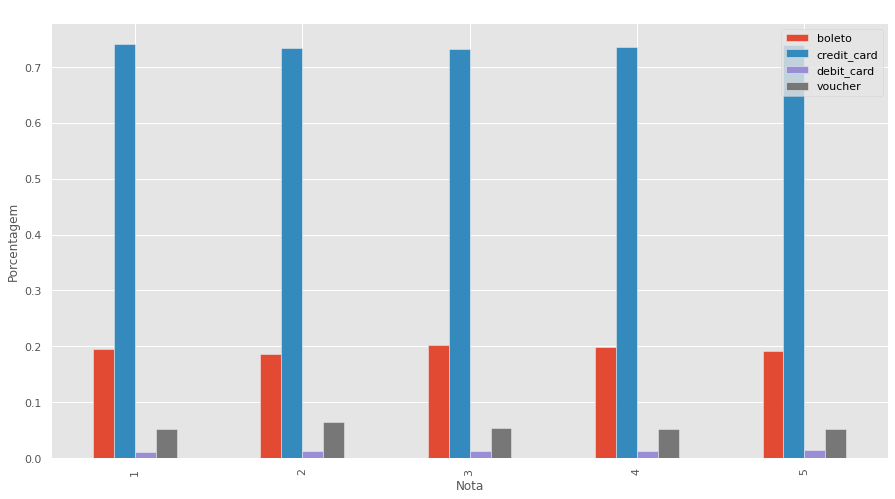

In [369]:
pay_type_score.unstack().plot.bar(figsize=(15, 8)).legend(loc="best")
plt.ylabel("Porcentagem")
plt.xlabel("Nota")
legend = plt.legend()
plt.setp(legend.get_texts(), color='black')
plt.title("Relação entre tipo de pagamento e nota de review")
plt.show()


<h2>Vemos que a distribuição não muda conforme a nota avaliativa. Logo, para vermos se isso é 'força do acaso' ou não, lançaremos mão de um teste estatístico não paramétrico chi-quadrado com nível de significância alfa=0,05 para avaliar a independência dessas duas variáveis de teste </h2>
</p>
<h2>As hipóteses de teste são:
<ul>
<li>Hipótese nula: Não existe associação entre as variáveis (são independentes)</li>
<li>Hipótese alternativa: Existe associação entre as variáveis (não são independentes) </li>
</ul>
</h2>


In [312]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2.html
from scipy.stats import chi2_contingency, chi2

# Tabela de contingência
table = pd.crosstab(data["payment_type"], data["review_score"], margins=False)

chi_2, p_value, dof, expected = chi2_contingency(table)

alpha = 0.05
print("Nível de significância: ", alpha)
print("p-valor: ", p_value)

if p_value < alpha:
    print("Rejeita hipótese nula")
else:
    print("Não rejeita hipótese nula")
print("*"*30)

prob = 1 - alpha
critical = chi2.ppf(prob, dof)

print("O valor crítico: ", critical)
print("Chi2: ", chi_2)

if chi_2 >= critical:
    print("Rejeita hipótese nula")
else:
    print("Não rejeita hipótese nula")


Nível de significância:  0.05
p-valor:  0.0002740429070471017
Rejeita hipótese nula
******************************
O valor crítico:  21.02606981748307
Chi2:  36.451510464607715
Rejeita hipótese nula


<h2>Isso nos leva a conclusão que existe uma dependência significante entre as notas e o tipo de pagamento. </h2>

<h2>2) Agora avaliemos a relação entre review_score (notas) e payment_installments (parcelas de pagamento) </h2>

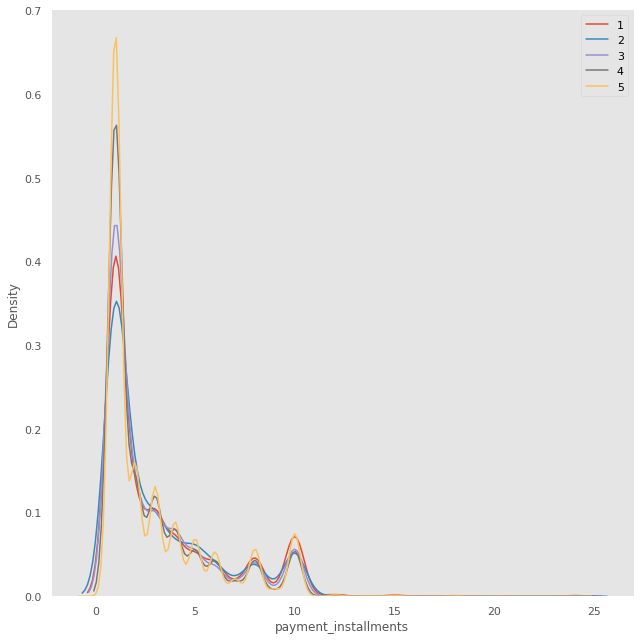

In [364]:

sns.FacetGrid(data, hue="review_score", height=9)\
    .map(sns.kdeplot, "payment_installments")
plt.grid(False)
legend = plt.legend()
plt.setp(legend.get_texts(), color='black')
plt.show()


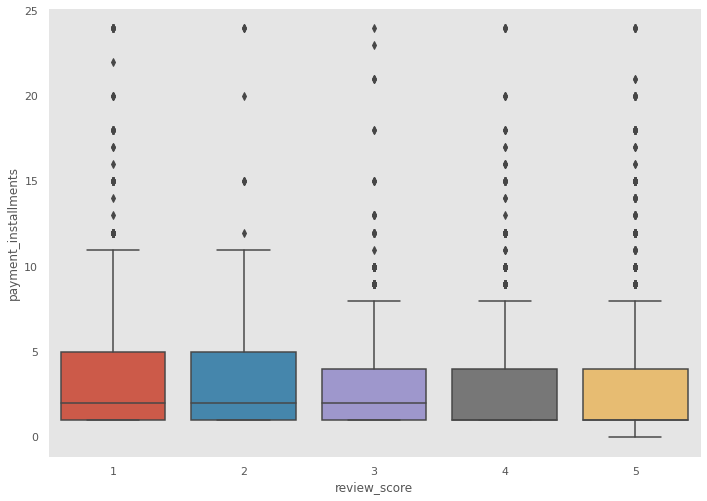

review_score
1    3.292425
2    3.149440
3    2.982451
4    2.807172
5    2.898157
Name: payment_installments, dtype: float64
review_score
1    24.000
2    15.365
3    15.000
4    15.000
5    15.000
Name: payment_installments, dtype: float64


In [370]:
sns.boxplot(y="payment_installments", x="review_score", data=data)
plt.grid(False)

plt.show()

print(data.groupby("review_score")["payment_installments"].mean())
print(data.groupby("review_score")["payment_installments"].apply(
    lambda x: np.percentile(x, 99.9)))


<h2>Podemos concluir com essa relação:
<ul>
<li>As distribuições são bem coincidentes em torno do valor de 1 parcela</li>
<li>As distribuições são muito similares em torno de todas as parcelas</li>
<li>Há outliers para todas as notas</li>
<li>Há poucos pontos de dados que têm parcelas maiores que 10 em cada avaliação</li>
<li>A mediana das avaliações 1,2,3 são próximas de 2, enquanto que a mediana das avaliações 4,5 são próximas de 1</li>
<li>Maior parte dos dados (75% - quartil 3) com avaliação 3, 4 e 5 têm parcelas inferiores a 5. Para as avaliações com nota 1 e 2, a maior parte das parcelas não ultrapassam 5</li>
<li>As médias de parcelas para as notas 1 e 2 são mais elevadas que as médias das parcelas para as notas 3 e 4, mas não significativamente relevante</li>
<li>99,9% dos dado se encontram abaixo da 15º parcela de pagamento, com exceção dos dados agrupados para nota 1</li>
<ul>
</h2>

<h2>3) Para a variável <i>payment_sequential</i>, estudemos suas relações. Essa variável nada mais é do que a quantidade de meios de pagamento que o cliente escolheu na hora do pagamento, variando de 1 a 26.</h2>

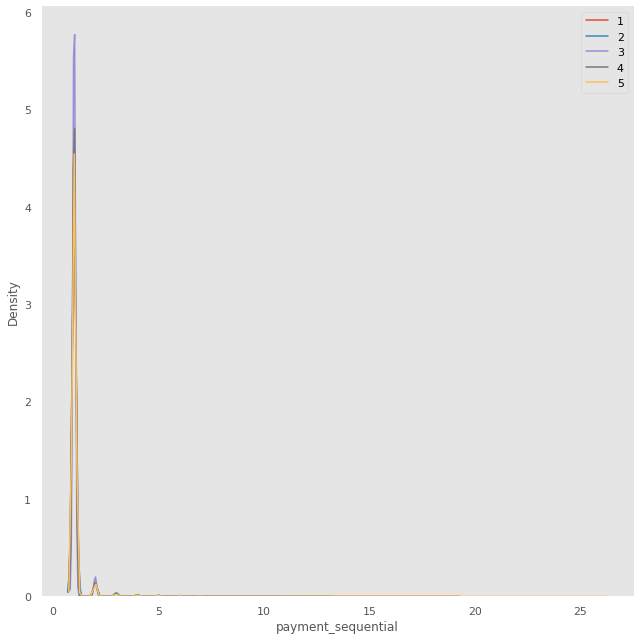

In [374]:
sns.FacetGrid(data, hue="review_score", height=9)\
    .map(sns.kdeplot, "payment_sequential")
legend = plt.legend()
plt.setp(legend.get_texts(), color='black')
plt.grid(False)
plt.show()


<h2>Mesmo os dados estando muito sobrepostos, é possível ver que a sequencia de pagamentos é maior quando a nota é 3 e elas são muito concentradas em 1 parcela e minoritariamente em 3 parcelas.</p> É muito difícil distinguir qualquer informação entre as notas nesse gráfico, com dados muito sobrepostos. Nesse caso, o <i>payment_sequential</i> não nos fornece nenhuma informação interessante</p> Analisemos um boxplot e alguns percentis:<h2>

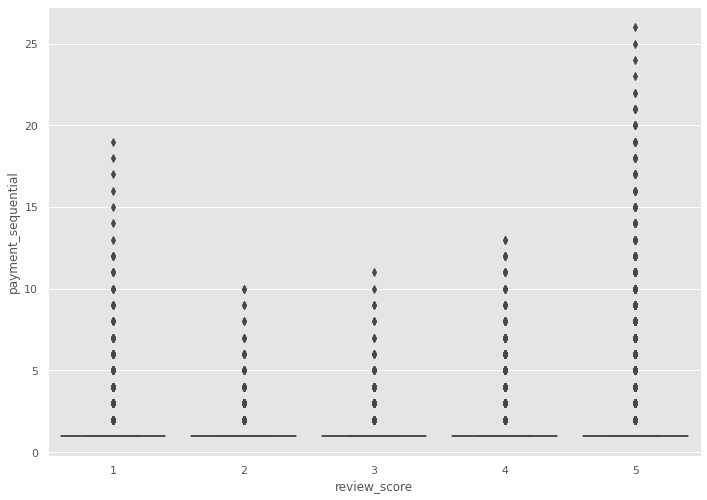

Média 
 review_score
1    1.085945
2    1.095468
3    1.062572
4    1.085435
5    1.096830
Name: payment_sequential, dtype: float64
99% percentil 
 review_score
1    3.0
2    3.0
3    3.0
4    3.0
5    3.0
Name: payment_sequential, dtype: float64


In [385]:
sns.boxplot(y="payment_sequential", x="review_score", data=data)
plt.show()

# média
print("Média \n", data.groupby("review_score")["payment_sequential"].mean())

#99% percentil (nos ajuda a melhor entender o comportamento do boxplot, ja que com tantos dados é muito dificil visualizar pequenos detalhes)
print("99% percentil \n", data.groupby("review_score")[
      "payment_sequential"].apply(lambda o: np.percentile(o, 99)))


<h2>Algumas conclusões podem ser tiradas:</p>

<li>A maioria esmagadora dos dados estão concentrados em um único meio de pagamento</li>
<li>A média é quase a mesma em todos os casos, sofrendo pouquíssima diferente entre as notas</li>
<li>99% de todos os dados estão concentrados no máximo em 3 meios de pagamento (pequeno pico no gráfico)</li>
<li>É muito evidente que essa variável sozinha não consegue nos fornecer qualquer informação relevante em relação as notas avaliativas</li>
</h2>

<h2>3) Agora, para a análise de correlação, vamos analisar a relação entre review_score e payment_value.</h2>

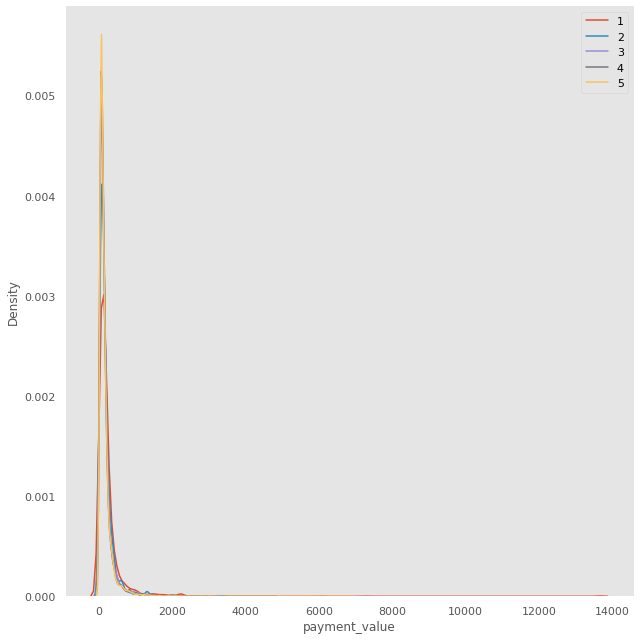

In [371]:
sns.FacetGrid(data, hue="review_score", height=9)\
    .map(sns.kdeplot, "payment_value")
legend = plt.legend()
plt.setp(legend.get_texts(), color='black')
plt.grid(False)
plt.show()


<h2>As densidades estão bem sobrepostas, logo, não podemos visualmente determinar qualquer correlação mais claramente. Para isso, olhemos para os números:</h2>

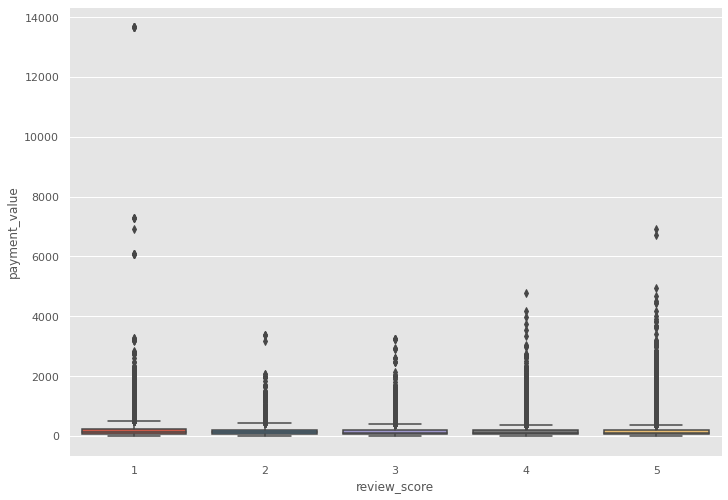

Mpedia 
 review_score
1    238.378781
2    185.455339
3    168.537174
4    164.145464
5    161.241691
Name: payment_value, dtype: float64
Percentil de 90% 
 review_score
1    464.890
2    372.840
3    334.414
4    323.905
5    317.850
Name: payment_value, dtype: float64


In [316]:
sns.boxplot(y="payment_value", x="review_score", data=data)
plt.show()

# média do valor do pagamento
print("Mpedia \n", data.groupby("review_score")["payment_value"].mean())

#90% percentil
print("Percentil de 90% \n", data.groupby("review_score")[
      "payment_value"].apply(lambda x: np.percentile(x, 90)))


<h2>
Algumas conclusões:
<ul>
<li>A média dos valores para as notas 3, 4, 5 é muito menor comparativamente que a média para a nota 1</li>
<li> No boxplot podemos ver que há pagamentos com altos valores para a nota 1, isso eleva a média de pagamentos para essa nota</li>
<li>Com 90% dos dados ainda assim, o valor para a nota 1 ainda assim é bastante maior que os outros valores</li>
</ul>
</p>
Como foi observado, para a nota 1, temos outliers muito discrepantes, com valores de pagamento acima de 8000. Analisemos eles mais profundadamente:
</h2>

In [317]:
rate1 = data[data["review_score"] == 1]
rate1[rate1["payment_value"] > 8000]


,order_id,payment_sequential,payment_type,payment_installments,payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_item_id,seller_id,shipping_limit_date,price,freight_value,zip_code_prefix_seller,lat_seller,lng_seller,seller_city,seller_state
59174,03caa2c082116e1d31e67e9ae3700499,1,credit_card,1,13664.08,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,...,1,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,3667,-23.532047,-46.496814,sao paulo,SP
59175,03caa2c082116e1d31e67e9ae3700499,1,credit_card,1,13664.08,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,...,2,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,3667,-23.532047,-46.496814,sao paulo,SP
59176,03caa2c082116e1d31e67e9ae3700499,1,credit_card,1,13664.08,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,...,3,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,3667,-23.532047,-46.496814,sao paulo,SP
59177,03caa2c082116e1d31e67e9ae3700499,1,credit_card,1,13664.08,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,...,4,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,3667,-23.532047,-46.496814,sao paulo,SP
59178,03caa2c082116e1d31e67e9ae3700499,1,credit_card,1,13664.08,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,...,5,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,3667,-23.532047,-46.496814,sao paulo,SP
59179,03caa2c082116e1d31e67e9ae3700499,1,credit_card,1,13664.08,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,...,6,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,3667,-23.532047,-46.496814,sao paulo,SP
59180,03caa2c082116e1d31e67e9ae3700499,1,credit_card,1,13664.08,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,...,7,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,3667,-23.532047,-46.496814,sao paulo,SP
59181,03caa2c082116e1d31e67e9ae3700499,1,credit_card,1,13664.08,1617b1357756262bfa56ab541c47bc16,delivered,2017-09-29 15:24:52,2017-10-02 15:28:20,2017-10-10 15:43:17,...,8,b37c4c02bda3161a7546a4e6d222d5b2,2017-10-06 15:28:20,1680.0,28.01,3667,-23.532047,-46.496814,sao paulo,SP


<h2>Apenas um usuário comprou o mesmo produto oito vezes por 13664,08 e deu 8 vezes a mesma nota e isso afetou a média de pagamentos para a nota 1, elevando-a.</h2>

<h2>Checando um <i>range</i> de percentis:</h2>

In [318]:
for i in range(95, 100):
    print("Percentil em {}% \n {}".format(i, data.groupby("review_score")
          ["payment_value"].apply(lambda o: np.percentile(o, i))))
    print("*"*35)


Percentil em 95% 
 review_score
1    738.570
2    557.137
3    508.304
4    483.434
5    468.000
Name: payment_value, dtype: float64
***********************************
Percentil em 96% 
 review_score
1    854.1020
2    622.2800
3    581.2500
4    567.3064
5    545.1400
Name: payment_value, dtype: float64
***********************************
Percentil em 97% 
 review_score
1    1014.0200
2     697.0518
3     682.8300
4     660.4117
5     637.4382
Name: payment_value, dtype: float64
***********************************
Percentil em 98% 
 review_score
1    1342.98
2     939.72
3     835.55
4     838.97
5     783.00
Name: payment_value, dtype: float64
***********************************
Percentil em 99% 
 review_score
1    1853.0000
2    1308.1800
3    1076.7600
4    1150.0456
5    1071.1200
Name: payment_value, dtype: float64
***********************************


<h2>Temos que em todos os percentis os valores para review 3, 4 e 5 são consideravelmente menores que para nota 1. Agora, sigamos para cálculo com outros percentis:</h2>

In [319]:
lista = [50, 75, 80, 85]
for i in lista:
    print("Percentil em {}% \n {}".format(i, data.groupby("review_score")
          ["payment_value"].apply(lambda o: np.percentile(o, i))))
    print("*"*35)


Percentil em 50% 
 review_score
1    137.570
2    119.245
3    107.780
4    104.610
5    104.430
Name: payment_value, dtype: float64
***********************************
Percentil em 75% 
 review_score
1    241.220
2    212.320
3    188.340
4    182.290
5    180.135
Name: payment_value, dtype: float64
***********************************
Percentil em 80% 
 review_score
1    284.550
2    247.640
3    218.270
4    208.634
5    207.274
Name: payment_value, dtype: float64
***********************************
Percentil em 85% 
 review_score
1    350.220
2    297.950
3    260.140
4    249.670
5    244.803
Name: payment_value, dtype: float64
***********************************


<h2>Continuamos a observar um valor maior para nota 1, mesmo com percentis menores</h2>
<h2>E nisso, observando essas métricas, podemos dizer que o <span style="color:red"> valor do pagamento tem influência na nota dada </span>. Isso quer dizer que os clientes que compraram produtos com valores maiores têm a tendência em dar notas mais baixas no momento de avaliação. Todavia, isso não prova a casualidade dessa relação.</h2>